# Data Source

- [AIHub: 한국인 전신 형상 및 치수 측정 데이터(성인)](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=data&dataSetSn=560)

# Import Library

In [116]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil
import pickle

# Function

##### Label 및 Index 딕셔너리

In [2]:
Index2Label = {0: 'Background', 
               1: 'Head', 
               2: 'Torso', 
               3: 'Upper_Arms', 
               4: 'Lower_Arms', 
               5: 'Upper_Legs', 
               6: 'Lower_Legs'}

Label2Index = {'Background': 0, 
               'Head': 1, 
               'Torso': 2, 
               'Upper_Arms': 3, 
               'Lower_Arms': 4, 
               'Upper_Legs': 5, 
               'Lower_Legs': 6}

# Label2Index = {v: k for k, v in Index2Label.items()}

##### 이미지 경로 생성
- Input: 이미지 폴더 경로
- Output: 이미지 경로

In [3]:
def create_images_path(folder_path):
    folder_path = folder_path
    imges = os.listdir(folder_path)
    images_path = [os.path.join(folder_path, img) for img in imges]
    return images_path

##### 이미지 시각화 및 넘파이 배열 반환
- Input: 이미지경로, 시각화 유무(bool), 화면 전환 각도

In [20]:
def visualize_images(images_path, visualize=1, rotate=0): # Outputs\\01_01_F010_02.png, rotate 회전각 입력
    # Output
    images_names = []
    images_array = []
    
    for img in tqdm(images_path, desc="Processing images"):
        image_path = img
        image_name = os.path.basename(image_path)

        image = Image.open(image_path)

        # 이미지 회전 메타데이터를 자동으로 해석하여 회전시킴
        image = image.rotate(rotate, expand=True)  # 0은 회전 각도, expand=True는 이미지 크기 조정 (0 / 270)

        images_names.append(image_name)
        image_array = np.array(image)
        images_array.append(image_array)

        # Visualize Images -------------------> Option(On/Off)
        if visualize:
            
            print("Size of Image:", image.size)
            print("Mode of Image:", image.mode) # (RGB/L/P)
            
            # print("Shape of Image (Numpy ):", )
            
            
            plt.imshow(image)
            plt.title(f'{image_name}')
            plt.axis('off')  # 축 제거
            plt.show()
    else:
        pass

    return images_names, images_array

In [123]:
def palette_to_one_hot(palette_image_path, num_classes=7, imge_info=True, visualize=True):
    """
    팔레트 이미지를 원핫인코딩하여 (2940, 1960, 7) 형태의 이미지로 변환하는 함수

    Args:
    palette_image_path (str): 세그멘테이션된 P 모드의 PIL 팔레트 이미지 경로

    Returns:
    np.ndarray: 원핫인코딩된 이미지
    """
    # 클래스 수 정의 (배경 포함 1개)
    num_classes = num_classes

    # PIL 2 Numpy
    palette_image = Image.open(palette_image_path)
    palette_image_array = np.array(palette_image)

    # 원핫인코딩된 이미지를 저장할 배열 생성
    one_hot_encoded_image = np.zeros((*palette_image_array.shape, num_classes), dtype=np.uint8)

    # 각 픽셀을 원핫인코딩된 형태로 변환
    for i in range(palette_image_array.shape[0]): # 2940
        for j in range(palette_image_array.shape[1]): # 1960
            pixel_value = palette_image_array[i, j]  # 현재 픽셀의 값
            one_hot_encoded_image[i, j, pixel_value] = 1  # 해당 클래스에 대응하는 채널에 1 할당

    if imge_info:
        # 이미지 이름 출력
        image_name = os.path.basename(palette_image_path)
        print("Image Name:", image_name)
        print("Original Image Shape:", palette_image_array.shape)
        print("Transformed Image Shape:", one_hot_encoded_image.shape)
        print()
        
    if visualize:
        visualize_one_hot_encoded_image(one_hot_encoded_image,  Index2Label=Index2Label)
        
    return one_hot_encoded_image

In [69]:
def visualize_one_hot_encoded_image(one_hot_encoded_image, Index2Label=Index2Label):
    """
    원핫인코딩된 이미지를 시각화하고 클래스별로 따로 시각화하여 보여주는 함수

    Args:
    one_hot_encoded_image (np.ndarray): 원핫인코딩된 이미지

    Returns:
    None
    """
    # 이미지의 형태 출력
    print("Transformed Image Shape:", one_hot_encoded_image.shape)

    # 전체 이미지 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(one_hot_encoded_image.argmax(axis=2), cmap='viridis', interpolation='nearest')
    plt.title('Original Palette Image')
    plt.axis('off')
    plt.show()

    # 클래스별로 따로 시각화
    num_classes = one_hot_encoded_image.shape[2]
    for class_index in range(num_classes):
        class_image = one_hot_encoded_image[:, :, class_index]
        plt.figure(figsize=(8, 8))
        plt.imshow(class_image, cmap='gray')
        plt.title(f'Class: {class_index} {Index2Label[class_index]}')
        plt.axis('off')
        plt.show()

In [ ]:
def save_images_pkl_with_one_hot_encoding(images_paths, output_folder_path, num_classes=7, imge_info=True, visualize=False):
    """
    이미지를 원핫인코딩하여 새로운 폴더에 저장하는 함수

    Args:
    images_paths (list): 이미지 파일 경로의 리스트
    output_folder_path (str): 이미지를 저장할 폴더 이름(현재 경로에 저장)
    num_classes (int): segmentation 세그멘테이션 클래스 개수(배경 포함)
    imge_info (bool): 이미지 정보 출력 토글(default: True)
    visualize (bool): 이미지 시각화 토글(default: False)

    Returns:
    None
    """
    # 새로운 폴더 생성
    os.makedirs(output_folder_path, exist_ok=True)
    
    # one_hot_encoded_images
    one_hot_encoded_images = []

    # 원핫 인코딩 수행
    for img_path in tqdm(images_paths, desc='Encoding images'):
        
        # PIL Pallete 2 Numpy
        one_hot_encoded_image = palette_to_one_hot(img_path, num_classes=num_classes, imge_info=imge_info, visualize=visualize)
        one_hot_encoded_images.append(one_hot_encoded_image)
        
    # 저장할 경로 설정
    save_path = os.path.join(output_folder_path, f"one_hot_encoded_images_array.pkl") 
        
    # 이미지 데이터를 피클로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(one_hot_encoded_images, f)

In [ ]:
import pickle

def save_images_pkl_with_one_hot_encoding(images_paths, output_folder_path, num_classes=7, imge_info=True, visualize=False):
    """
    이미지를 원핫인코딩하여 새로운 폴더에 저장하는 함수

    Args:
    images_paths (list): 이미지 파일 경로의 리스트
    output_folder_path (str): 이미지를 저장할 폴더 이름(현재 경로에 저장)
    num_classes (int): segmentation 세그멘테이션 클래스 개수(배경 포함)
    imge_info (bool): 이미지 정보 출력 토글(default: True)
    visualize (bool): 이미지 시각화 토글(default: False)

    Returns:
    None
    """
    # 새로운 폴더 생성
    os.makedirs(output_folder_path, exist_ok=True)
    
    # one_hot_encoded_images
    one_hot_encoded_images = []

    # 원핫 인코딩 수행
    for img_path in tqdm(images_paths, desc='Encoding images'):
        
        # PIL Pallete 2 Numpy
        one_hot_encoded_image = palette_to_one_hot(img_path, num_classes=num_classes, imge_info=imge_info, visualize=visualize)
        one_hot_encoded_images.append(one_hot_encoded_image)
        
    # 저장할 경로 설정
    save_path = os.path.join(output_folder_path, f"one_hot_encoded_images_array.pkl") 
        
    # 이미지 데이터를 피클로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(one_hot_encoded_images, f)

# Test

In [ ]:
"D:\알파코\SCHP\Seg_Inspect\seg_crop\01\01_00_F001_01.png"

In [ ]:
"D:\알파코\SCHP\Seg_Inspect\seg_crop"

In [78]:
base_folder_path = r'D:\알파코\SCHP\Seg_Inspect\seg_crop'
angles = os.listdir(base_folder_path) # 1 ~ 32

print(len(angles))
print(angles[0])

32
01


In [25]:
base_folder_path

'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop'

In [7]:
angle_1_path = os.path.join(base_folder_path, angles[0]) # 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01

print(angle_1_path)

D:\알파코\SCHP\Seg_Inspect\seg_crop\01


In [15]:
test_seg_path = create_images_path(angle_1_path) # 872개
test_imges = test_seg_path[:10] # 10개만 사용

print(f'Total: {len(test_seg_path)}') # 872 (촬영 각도1 이미지)
print(f'test omges: {len(test_imges)}')

Total: 872
test omges: 10


In [16]:
test_imges

['D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_00_F001_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_00_F002_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_00_F003_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_00_M002_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F001_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F002_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F003_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F004_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F017_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F018_01.png']

In [154]:
test_path = r"D:\알파코\SCHP\Seg_Inspect\seg_crop\01\01_00_F001_01.png"

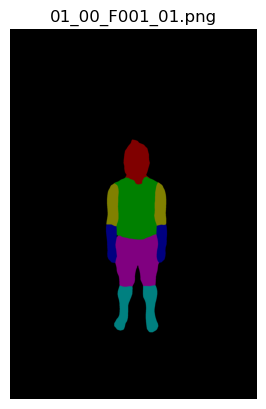

In [155]:
img = Image.open(test_path)

image_name = os.path.basename(test_path)

plt.imshow(img)
plt.title(f'{image_name}')
plt.axis('off')
plt.show()

In [156]:
test_image = palette_to_one_hot(test_path, visualize=False)

Image Name: 01_00_F001_01.png
Original Image Shape: (2940, 1960)
Transformed Image Shape: (2940, 1960, 7)



Image Name: 01_00_F001_01.png
Original Image Shape: (2940, 1960)
Transformed Image Shape: (2940, 1960, 7)

Transformed Image Shape: (2940, 1960, 7)


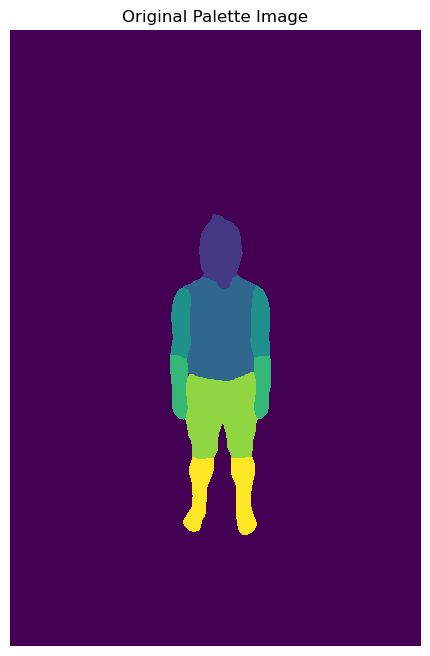

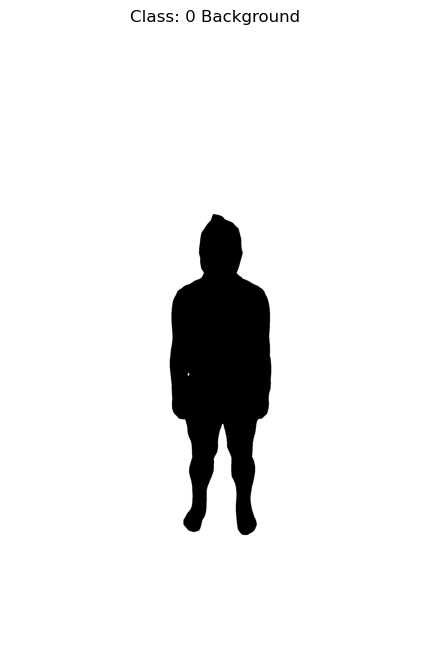

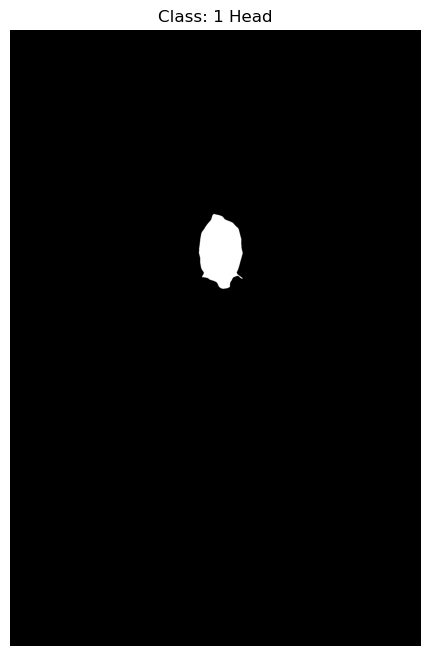

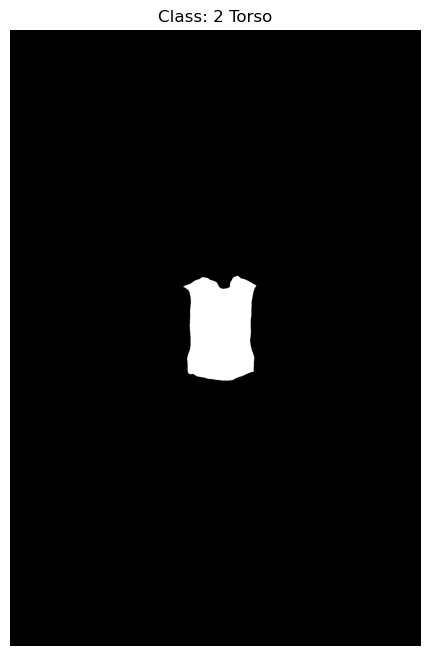

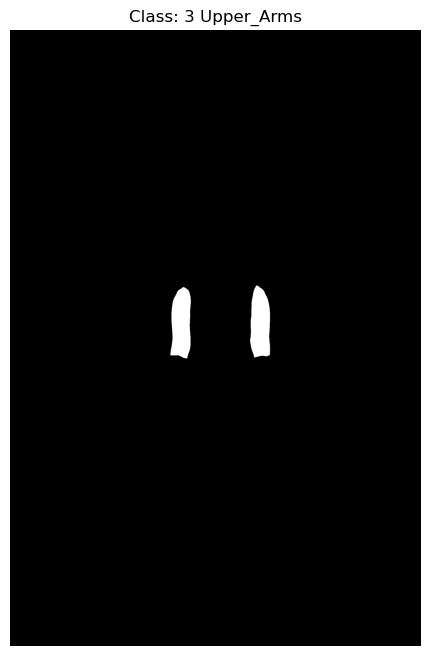

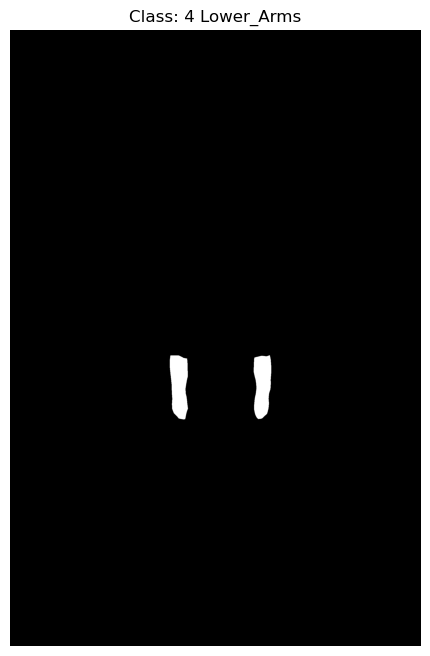

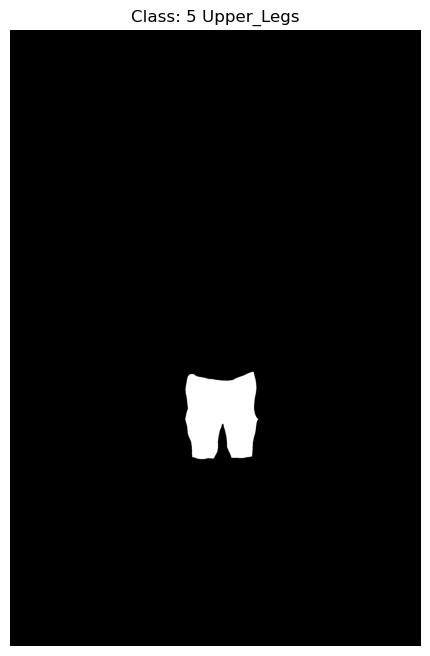

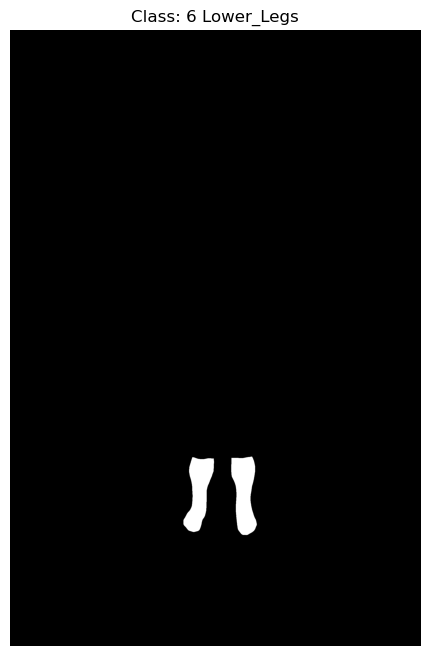

In [157]:
test_image = palette_to_one_hot(test_path, imge_info=True, visualize=True)

In [ ]:
test_image

In [158]:
import matplotlib.pyplot as plt

# 다양한 컬러맵 사용 예시
# cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'gray', 
#          'bone', 'pink', 'spring', 'summer', 'autumn', 'winter', 
#          'cool', 'hot', 'jet', 'hsv', 'twilight', 'twilight_shifted', 'cubehelix', 'gnuplot']

# for cmap in cmaps:
#     plt.imshow(test_image.argmax(axis=2), cmap=cmap, interpolation='nearest')
#     plt.title(f'{cmap.capitalize()} Colormap')
#     plt.axis('off')
#     plt.show()

# Task

##### `base_folder_path, output_folder, test_imges(이미지 경로)` 입력 필요

In [117]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil
import pickle

In [127]:
base_folder_path = r'D:\알파코\SCHP\Seg_Inspect\seg_crop'

base_folder_path = base_folder_path
angles = os.listdir(base_folder_path) # 1 ~ 32
angle_1_path = os.path.join(base_folder_path, angles[0]) # 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01
test_seg_path = create_images_path(angle_1_path) # 872개
test_imges = test_seg_path[:10] # 10개만 사용

output_folder = os.path.join(os.getcwd(), 'one_hot_img_array')

print(f'현재 경로: {os.getcwd()}')
print(f'원본 이미지 경로: {base_folder_path}')
print(f'결과 이미지 저장 경로: {output_folder}')
print(f'전체 {len(test_seg_path)}장 중 {len(test_imges)}장 적용')

현재 경로: d:\알파코\0227
원본 이미지 경로: D:\알파코\SCHP\Seg_Inspect\seg_crop
결과 이미지 저장 경로: d:\알파코\0227\one_hot_img_array
전체 872장 중 10장 적용


In [143]:
test_imges

['D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_00_F001_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_00_F002_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_00_F003_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_00_M002_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F001_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F002_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F003_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F004_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F017_01.png',
 'D:\\알파코\\SCHP\\Seg_Inspect\\seg_crop\\01\\01_01_F018_01.png']

In [86]:
Index2Label = {0: 'Background', 
               1: 'Head', 
               2: 'Torso', 
               3: 'Upper_Arms', 
               4: 'Lower_Arms', 
               5: 'Upper_Legs', 
               6: 'Lower_Legs'}

In [114]:
from PIL import Image

def save_images2pkl_with_one_hot_encoding(images_paths, output_folder_path, num_classes=7, imge_info=True, visualize=False):
    """
    이미지를 원핫인코딩하여 새로운 폴더에 저장하는 함수

    Args:
    images_paths (list): 이미지 파일 경로의 리스트
    output_folder_path (str): 이미지를 저장할 폴더 이름(현재 경로에 저장)
    num_classes (int): segmentation 세그멘테이션 클래스 개수(배경 포함)
    imge_info (bool): 이미지 정보 출력 토글(default: True)
    visualize (bool): 이미지 시각화 토글(default: False)

    Returns:
    None
    """
    # 새로운 폴더 생성
    os.makedirs(output_folder_path, exist_ok=True)

    # 이미지 저장
    for img_path in tqdm(images_paths, desc='Encoding images'):
        # 이미지 파일 이름 추출
        image_name = os.path.basename(img_path)
        
        # 팔레트 이미지를 원핫인코딩하여 가져오기
        one_hot_encoded_image = palette_to_one_hot(img_path, num_classes=num_classes, imge_info=imge_info, visualize=visualize)
        
        # 데이터 타입을 np.uint8로 변환
        one_hot_encoded_image = one_hot_encoded_image.astype(np.uint8)
        
        # 저장할 경로 설정
        save_path = os.path.join(output_folder_path, f"{image_name}.png")
        
        # 이미지를 PIL 이미지로 변환
        pil_image = Image.fromarray(one_hot_encoded_image)
        
        # 이미지 저장
        pil_image.save(save_path)


In [139]:
# Apply
save_images_pkl_with_one_hot_encoding(test_imges, output_folder, num_classes=7, imge_info=False, visualize=False)

Encoding images: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


In [140]:
# 피클 파일 경로
pickle_file_path = "one_hot_img_array/one_hot_encoded_images_array.pkl"

# 피클 파일 불러오기
with open(pickle_file_path, 'rb') as f:
    one_hot_encoded_images = pickle.load(f)

# 저장된 데이터 확인
print("Number of images:", len(one_hot_encoded_images))
print("Shape of each image:", one_hot_encoded_images[0].shape)

Number of images: 10
Shape of each image: (2940, 1960, 7)


In [141]:
print(type(one_hot_encoded_images))
print(type(one_hot_encoded_images[0]))

<class 'list'>
<class 'numpy.ndarray'>


Transformed Image Shape: (2940, 1960, 7)


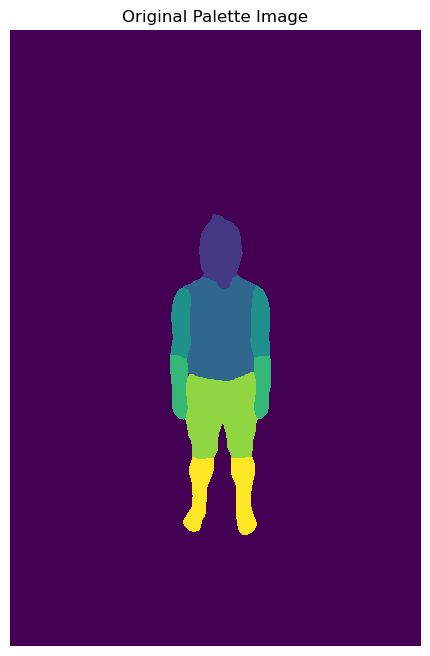

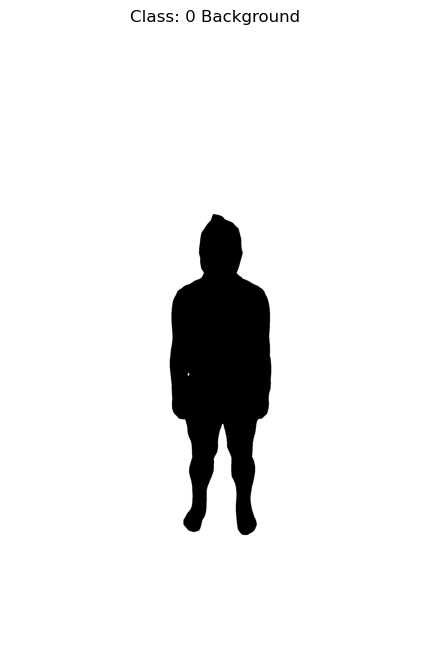

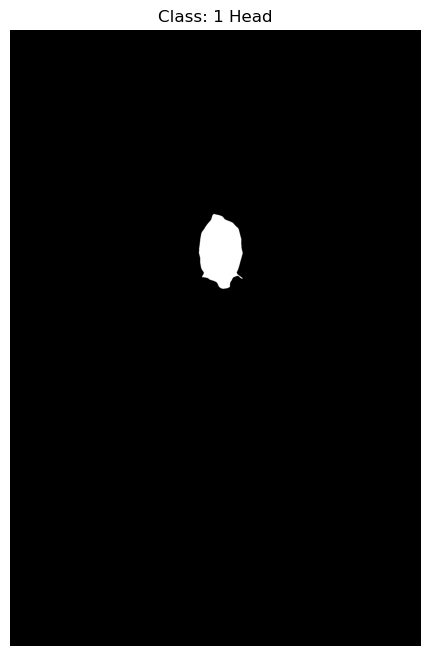

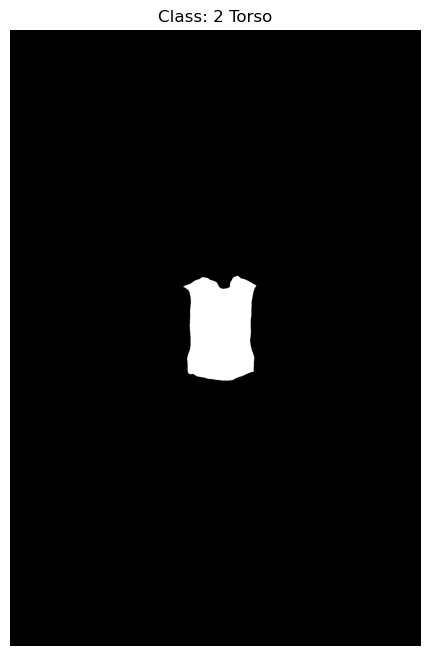

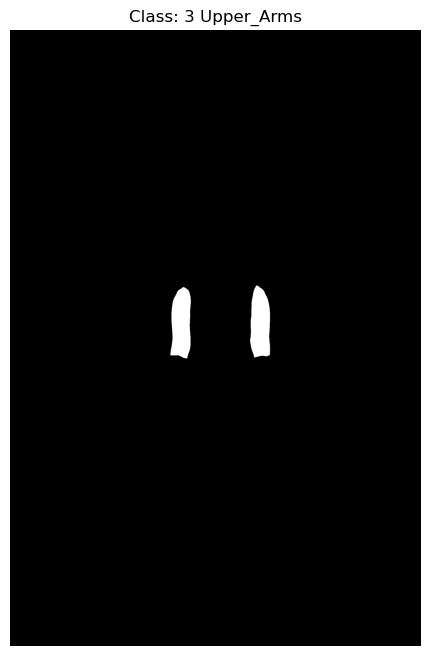

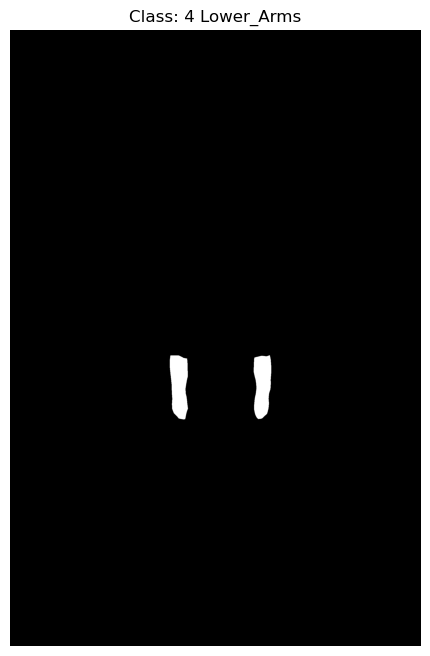

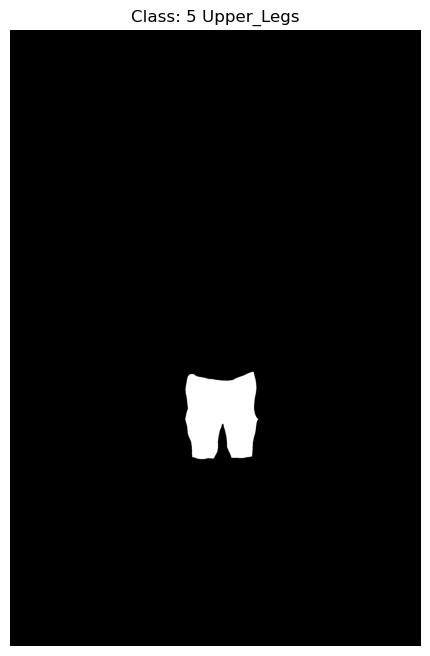

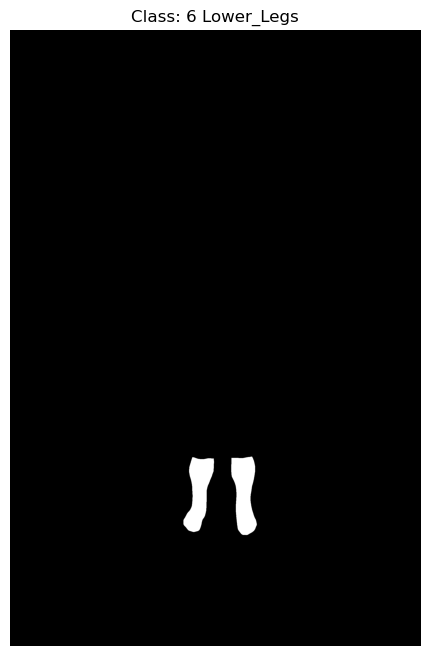

In [142]:
visualize_one_hot_encoded_image(one_hot_encoded_images[0])

In [160]:
print(type(test_image))
print(test_image.shape)

<class 'numpy.ndarray'>
(2940, 1960, 7)


In [163]:
import numpy as np
from PIL import Image

def save_segmentation_result(segmentation_array, filename):
    """
    세그멘테이션 결과를 이미지로 저장하는 함수
    Args:
    - segmentation_array: 세그멘테이션 결과를 나타내는 넘파이 배열 (세로, 가로, 채널 수)
    - filename: 저장할 이미지 파일의 경로 및 이름
    """
    # 넘파이 배열을 PIL 이미지로 변환
    segmentation_image = Image.fromarray(segmentation_array)

    # 이미지 저장
    segmentation_image.save(filename)
    print(f"세그멘테이션 결과를 이미지로 저장했습니다: {filename}")

def load_segmentation_result(filename):
    """
    저장된 세그멘테이션 이미지를 불러와서 넘파이 배열로 변환하는 함수
    Args:
    - filename: 불러올 이미지 파일의 경로 및 이름
    Returns:
    - segmentation_array: 세그멘테이션 결과를 나타내는 넘파이 배열 (세로, 가로, 채널 수)
    """
    # 이미지 불러오기
    segmentation_image = Image.open(filename)

    # 이미지를 넘파이 배열로 변환
    segmentation_array = np.array(segmentation_image)

    print(f"세그멘테이션 이미지를 불러왔습니다: {filename}")
    return segmentation_array


In [165]:
import numpy as np
from PIL import Image

def save_segmentation_result(segmentation_array, filename):
    """
    세그멘테이션 결과를 이미지 파일로 저장하는 함수
    Args:
    - segmentation_array: 세그멘테이션 결과를 나타내는 넘파이 배열 (세로, 가로, 채널 수)
    - filename: 저장할 이미지 파일의 경로 및 이름
    """
    # 넘파이 배열의 채널 수가 7이고 데이터 타입이 uint8인 경우에만 처리 가능
    if segmentation_array.shape[2] != 7 or segmentation_array.dtype != np.uint8:
        raise ValueError("세그멘테이션 결과의 형태가 잘못되었습니다.")

    # 세그멘테이션 결과를 RGB 이미지로 변환
    segmentation_rgb = segmentation_array[..., :3]  # 처음 3개 채널을 사용하여 RGB 이미지로 변환
    segmentation_image = Image.fromarray(segmentation_rgb)

    # 이미지 저장
    segmentation_image.save(filename)
    print(f"세그멘테이션 결과를 이미지로 저장했습니다: {filename}")

# 세그멘테이션 결과 넘파이 배열 생성 예시
segmentation_array = np.random.randint(0, 255, size=(2940, 1960, 7), dtype=np.uint8)

# 세그멘테이션 결과를 이미지로 저장
save_segmentation_result(segmentation_array, "segmentation_result.png")


세그멘테이션 결과를 이미지로 저장했습니다: segmentation_result.png


In [166]:
from PIL import Image

def load_segmentation_result(filename):
    """
    저장된 세그멘테이션 이미지를 불러오는 함수
    Args:
    - filename: 불러올 이미지 파일의 경로 및 이름
    Returns:
    - segmentation_image: 세그멘테이션 결과를 나타내는 PIL 이미지
    """
    # 이미지 불러오기
    segmentation_image = Image.open(filename)

    print(f"세그멘테이션 이미지를 불러왔습니다: {filename}")
    return segmentation_image

# 저장된 세그멘테이션 이미지를 불러오기
loaded_segmentation_image = load_segmentation_result("segmentation_result.png")

# 로드된 세그멘테이션 이미지를 확인
print("로드된 세그멘테이션 이미지의 크기:", loaded_segmentation_image.size)


세그멘테이션 이미지를 불러왔습니다: segmentation_result.png
로드된 세그멘테이션 이미지의 크기: (1960, 2940)


In [169]:
np.array(loaded_segmentation_image).shape

(2940, 1960, 3)

# Task 2. (02.28)

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil
import pickle

In [187]:
# 각도를 이름으로 저장하기 위한 함수 수정

def ANGLE_save_images_pkl_with_one_hot_encoding(images_paths, output_folder_path, num_classes=7, imge_info=True, visualize=False):
    """
    이미지를 원핫인코딩하여 새로운 폴더에 저장하는 함수

    Args:
    images_paths (list): 이미지 파일 경로의 리스트
    output_folder_path (str): 이미지를 저장할 폴더 이름(현재 경로에 저장)
    num_classes (int): segmentation 세그멘테이션 클래스 개수(배경 포함)
    imge_info (bool): 이미지 정보 출력 토글(default: True)
    visualize (bool): 이미지 시각화 토글(default: False)

    Returns:
    None
    """
    # 새로운 폴더 생성
    os.makedirs(output_folder_path, exist_ok=True)
    
    # one_hot_encoded_images
    one_hot_encoded_images = []

    # 원핫 인코딩 수행
    for img_path in tqdm(images_paths, desc='Encoding images'):
        
        # PIL Pallete 2 Numpy
        one_hot_encoded_image = palette_to_one_hot(img_path, num_classes=num_classes, imge_info=imge_info, visualize=visualize)
        one_hot_encoded_images.append(one_hot_encoded_image)
        
    # 저장할 경로 설정
    save_path = os.path.join(output_folder_path, f"one_hot_encoded_images_array_{ang}.pkl") 
        
    # 이미지 데이터를 피클로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(one_hot_encoded_images, f)

In [ ]:
print('sdfa\n')
print('sf')

In [188]:
base_folder_path = r"D:\알파코\SCHP\Seg_Inspect\seg_crop"
output_folder_path = 'one_hpt_encoded_array_pkls'

os.makedirs(output_folder_path, exist_ok=True)

angles = os.listdir(base_folder_path)

for ang in angles:
    angle_path = os.path.join(base_folder_path, ang) # 1~32
    angle_imges_path = create_images_path(angle_path) # 각도별 촬영 이미지
    
    print(f'Angle {ang} is processing.\n')
    
    ANGLE_save_images_pkl_with_one_hot_encoding(angle_imges_path,
                                                output_folder_path,  
                                                num_classes=7, 
                                                imge_info=False, 
                                                visualize=False)
    print(f'Angle {ang} is successly processed./n')
    
    break


Encoding images:   0%|          | 0/872 [00:00<?, ?it/s]

Encoding images: 100%|██████████| 872/872 [16:11<00:00,  1.11s/it]


MemoryError: 

In [198]:
def palette_to_one_hot(palette_image_path, num_classes=7, imge_info=True, visualize=True):
    """
    팔레트 이미지를 원핫인코딩하여 (2940, 1960, 7) 형태의 이미지로 변환하는 함수

    Args:
    palette_image_path (str): 세그멘테이션된 P 모드의 PIL 팔레트 이미지 경로

    Returns:
    np.ndarray: 원핫인코딩된 이미지
    """
    # 클래스 수 정의 (배경 포함 1개)
    num_classes = num_classes

    # PIL 2 Numpy
    palette_image = Image.open(palette_image_path)
    palette_image_array = np.array(palette_image)

    # 원핫인코딩된 이미지를 저장할 배열 생성
    one_hot_encoded_image = np.zeros((*palette_image_array.shape, num_classes), dtype=np.uint8)

    # 각 픽셀을 원핫인코딩된 형태로 변환
    for i in range(palette_image_array.shape[0]): # 2940
        for j in range(palette_image_array.shape[1]): # 1960
            pixel_value = palette_image_array[i, j]  # 현재 픽셀의 값
            one_hot_encoded_image[i, j, pixel_value] = 1  # 해당 클래스에 대응하는 채널에 1 할당

    if imge_info:
        # 이미지 이름 출력
        image_name = os.path.basename(palette_image_path)
        print("Image Name:", image_name)
        print("Original Image Shape:", palette_image_array.shape)
        print("Transformed Image Shape:", one_hot_encoded_image.shape)
        print()
        
    if visualize:
        visualize_one_hot_encoded_image(one_hot_encoded_image,  Index2Label=Index2Label)
        
    return one_hot_encoded_image

In [199]:
base_folder_path = r"D:\알파코\SCHP\Seg_Inspect\seg_crop"
# output_folder_path = 'one_hpt_encoded_array_pkls'
# os.makedirs(output_folder_path, exist_ok=True)

angles = os.listdir(base_folder_path)

total_images = []

for ang in angles:
    print(f'Angle {ang} is processing.\n')  
    angle_path = os.path.join(base_folder_path, ang) # 1~32
    angle_imges_path = create_images_path(angle_path) # 각도별 촬영 이미지
    
    angle_images = []
    
    for image in angle_imges_path:
        encoded_image = palette_to_one_hot(image, num_classes=7, imge_info=False, visualize=False)
        angle_images.append(encoded_image)
        
    total_images.append(angle_images)
    
    print(f'Angle {ang} is successly processed./n')
   
   
    print(len(total_images))
    print(len(angle_images))
   
    break


Angle 01 is processing.

